## Load and Preprocessing the data

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("news.csv")

# Check data
print(df.head())

# Drop missing values
df.dropna(inplace=True)

# Text cleaning function
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Encode labels
df['label'] = df['label'].map({'FAKE': 0, 'REAL': 1})

print(df[['text', 'clean_text', 'label']].head())


   Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                                text  \
0  Daniel Greenfield, a Shillman Journalism Fello...   
1  Google Pinterest Digg Linkedin Reddit Stumbleu...   
2  U.S. Secretary of State John F. Kerry said Mon...   
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...   
4  It's primary day in New York and front-runners...   

                                          clean_text  label  
0  daniel greenfield shillman journalism fellow f...      0  
1  google pinterest digg linkedin reddit stumbleu...      0  
2  u secretary state john f kerry said monday sto...      1  
3  kaydee king kaydeeking november 9 2016 lesson ...      0  
4  primary day new york front runners hillary cli...      1  


## **Exploratory Data Analysis (EDA)**

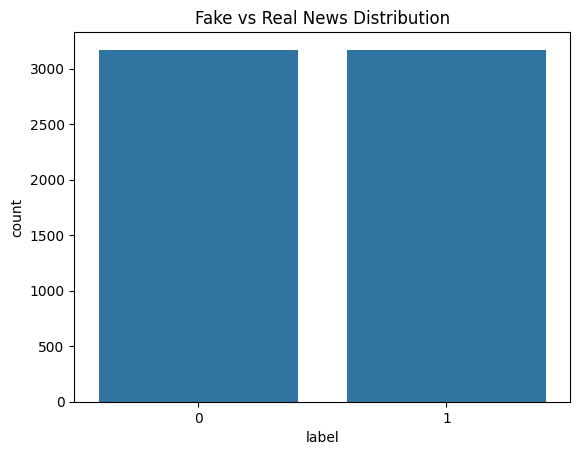

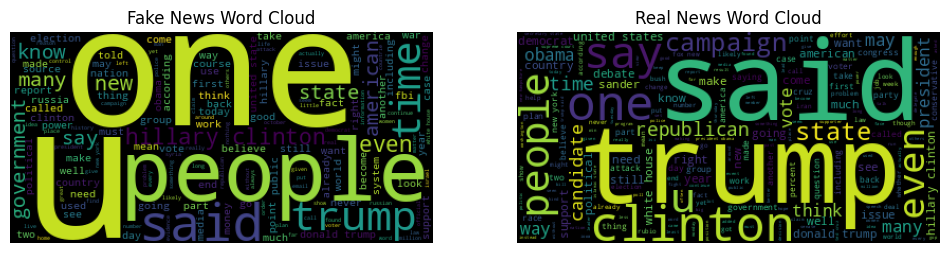

In [ ]:
# Visualize label distribution
sns.countplot(x=df['label'])
plt.title("Fake vs Real News Distribution")
plt.show()

# WordCloud for fake news
fake_text = ' '.join(df[df['label'] == 0]['clean_text'])
real_text = ' '.join(df[df['label'] == 1]['clean_text'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Fake News Word Cloud")
plt.imshow(WordCloud(width=400, height=200).generate(fake_text))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Real News Word Cloud")
plt.imshow(WordCloud(width=400, height=200).generate(real_text))
plt.axis('off')

plt.show()


## **TF-IDF Vectorization & Logistic Regression**

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Evaluate Model
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9179163378058406
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       628
           1       0.93      0.91      0.92       639

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



## **LSTM Model for Deep Learning Approach**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenize text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=300)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=300)

# Define LSTM model
model = Sequential([
    Embedding(5000, 128, input_length=300),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train_seq, y_train, epochs=5, batch_size=64, validation_data=(X_test_seq, y_test))

# Evaluate
y_pred_lstm = (model.predict(X_test_seq) > 0.5).astype("int32")
print("LSTM Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6847 - loss: 0.5983 - val_accuracy: 0.8785 - val_loss: 0.3113
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.8962 - loss: 0.2726 - val_accuracy: 0.8666 - val_loss: 0.3003
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9416 - loss: 0.1680 - val_accuracy: 0.8603 - val_loss: 0.3353
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9650 - loss: 0.1125 - val_accuracy: 0.8887 - val_loss: 0.3848
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.9786 - loss: 0.0782 - val_accuracy: 0.8737 - val_loss: 0.4381
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step
LSTM Accuracy: 0.8737174427782163
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.85      0.87       628
           1       0.86      0.90      0.88       639

    accuracy                           0.87      1267
   macro avg       0.87      0.87      0.87      1267
weight